In [48]:
import pandas as pd
import numpy as np
import seaborn as sns
import copy as cp
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, cross_val_predict 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score

from typing import Tuple

In [2]:
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_row", 160)
pd.set_option('max_colwidth', 200)

In [3]:
a = pd.read_csv('../../Data/accepted.csv')
a.head(3)

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.action?loan_id=68407277,NaN,debt_consolidation,Debt consolidation,190xx,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,30.0,NaN,7.0,0.0,2765.0,29.7,13.0,w,0.0,0.0,4421.723917,4421.72,3600.0,821.72,0.0,0.0,0.0,Jan-2019,122.67,NaN,Mar-2019,564.0,560.0,0.0,30.0,1.0,Individual,NaN,NaN,NaN,0.0,722.0,144904.0,2.0,2.0,0.0,1.0,21.0,4981.0,36.0,3.0,3.0,722.0,34.0,9300.0,3.0,1.0,4.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,69.0,4.0,69.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.action?loan_id=68355089,NaN,small_business,Business,577xx,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,6.0,NaN,22.0,0.0,21470.0,19.2,38.0,w,0.0,0.0,25679.660000,25679.66,24700.0,979.66,0.0,0.0,0.0,Jun-2016,926.35,NaN,Mar-2019,699.0,695.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,204396.0,1.0,1.0,0.0,1.0,19.0,18005.0,73.0,2.0,3.0,6472.0,29.0,111800.0,0.0,0.0,6.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,NaN,0.0,6.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,246

In [4]:
a.shape

(2260701, 151)

In [5]:
#Remove all obserations with No Funded Amount First, How many:
print(len(a[a.funded_amnt.isnull()]))

33


In [6]:
drop = a[a.funded_amnt.isnull()].index
a.drop(drop, axis=0, inplace=True)
a.shape

(2260668, 151)

In [7]:
#No more NaN funded amounts: 
a[a.funded_amnt.isna()].shape

(0, 151)

In [8]:
#Create new column and map Charged Off = 0, Fully Paid = 1
a['loan_status_bin'] = a['loan_status'].map({'Charged Off':0, 'Fully Paid':1})

In [9]:
#Drop all loans which do not classify as "Fully Paid" or "Charged Off":
drop2 = a[a.loan_status_bin.isnull()].index
a.drop(drop2, axis=0, inplace=True)
a.shape

(1345310, 152)

In [10]:
#Taking all loans with interest rate greater than or equal to 20%: 
a = a[a.int_rate >= 20].reset_index(drop=True)
a.shape

(110144, 152)

In [11]:
#Remove all observations with "Joint Applications". 
a = a[a.application_type == 'Individual']
a.shape

(106009, 152)

In [12]:
#Overall Return On Investment If Invested In All Loans > 20% interes rate ==> -3.6%
a['total_pymnt_inv'].sum() / a['funded_amnt_inv'].sum()

0.9643770437148663

In [13]:
data = pd.read_csv('../../Data/20x45B_All.csv')
data.head(5)

,loan_amnt,annual_inc,dti,fico_range_low,fico_range_high,int_rate,installment,open_acc,total_acc,revol_bal,inq_last_6mths,delinq_2yrs,acc_now_delinq,collections_12_mths_ex_med,pub_rec,months_cr_line,term,initial_list_status,grade,sub_grade,emp_length,ANY,MORTGAGE,NONE,OTHER,OWN,RENT,car,credit_card,debt_consolidation,educational,home_improvement,house,major_purchase,medical,moving,other,renewable_energy,small_business,vacation,wedding,Not Verified,Source Verified,Verified,loan_status_bin
0,-0.805788,0.544423,0.570300,0.663197,0.663194,-0.388527,-0.928141,0.020404,0.814165,0.277188,1.683433,0.681092,-0.074467,-0.125292,-0.377704,0.341665,0.729709,1.019288,0.837092,0.319365,-0.684242,-0.017646,1.099265,-0.007523,-0.007523,-0.358603,-0.873547,-0.084014,-0.342123,-1.311086,-0.003071,-0.252444,-0.117473,6.888409,-0.123241,-0.114845,-0.323001,-0.037391,-0.171212,-0.082752,-0.052011,-0.372811,1.298703,-1.011585,1.0
1,0.650069,0.015948,0.055254,-1.040497,-1.040493,0.282002,0.487904,1.071777,-0.307337,0.416038,-0.902143,-0.383738,-0.074467,-0.125292,-0.377704,-0.928019,0.729709,1.019288,0.837092,0.871554,-0.427946,-0.017646,1.099265,-0.007523,-0.007523,-0.358603,-0.873547,-0.084014,-0.342123,0.762727,-0.003071,-0.252444,-0.117473,-0.145171,-0.123241,-0.114845,-0.323001,-0.037391,-0.171212,-0.082752,-0.052011,2.682328,-0.769999,-1.011585,0.0
2,-0.232905,-0.522707,1.648144,3.583815,3.583802,-0.133801,-0.383561,1.071777,-0.067015,-0.358038,-0.040284,-0.383738,-0.074467,-0.125292,-0.377704,-0.892085,0.729709,-0.981077,0.837092,0.595459,1.109835,-0.017646,-0.909699,-0.007523,-0.007523,2.788603,-0.873547,-0.084014,-0.342123,0.762727,-0.003071,-0.252444,-0.117473,-0.145171,-0.123241,-0.114845,-0.323001,-0.037391,-0.171212,-0.082752,-0.052011,2.682328,-0.769999,-1.011585,1.0
3,0.529186,0.644379,0.008638,-1.040497,-1.040493,-1.118991,0.203558,-0.154825,-0.067015,0.212601,-0.902143,-0.383738,-0.074467,-0.125292,-0.377704,2.042563,0.729709,1.019288,-0.426533,-0.232824,-0.940539,-0.017646,-0.909699,-0.007523,-0.007523,2.788603,-0.873547,11.902814,-0.342123,-1.311086,-0.003071,-0.252444,-0.117473,-0.145171,-0.123241,-0.114845,-0.323001,-0.037391,-0.171212,-0.082752,-0.052011,2.682328,-0.769999,-1.011585,0.0
4,1.780067,0.823931,1.743649,0.906582,0.906578,-1.118991,1.300984,2.298379,2.336203,-0.106754,-0.902143,0.681092,-0.074467,-0.125292,-0.377704,0.868704,0.729709,1.019288,-0.426533,-0.232824,0.597242,-0.017646,1.099265,-0.007523,-0.007523,-0.358603,-0.873547,-0.084014,-0.342123,0.762727,-0.003071,-0.252444,-0.117473,-0.145171,-0.123241,-0.114845,-0.323001,-0.037391,-0.171212,-0.082752,-0.052011,-0.372811,1.298703,-1.011585,1.0


In [14]:
data.shape

(106009, 45)

In [15]:
data.loan_status_bin.value_counts()
#0 = Defaulted Loans
#1 = Loans Paid In Full

1.0    62957
0.0    43052
Name: loan_status_bin, dtype: int64

In [16]:
X = data.drop('loan_status_bin', axis=1)
X.shape

(106009, 44)

In [17]:
y = data['loan_status_bin']

In [18]:
lr1 = LogisticRegression()

In [19]:
steps = [('model', lr1)]
pipeline = Pipeline(steps=steps)

In [20]:
#Accuracy:

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1) 
print(scores)

score = np.mean(scores)
print(score)

[0.61937553 0.61503632 0.6194227  0.62182813 0.62195179]
0.6195228936118736


In [21]:
#Aggregated Confusion Matrix From RepeatedStratifiedKFold: 
y_pred = cross_val_predict(pipeline, X, y, cv=cv, n_jobs=-1)
conf_mat = confusion_matrix(y, y_pred)
conf_mat

array([[11910, 31142],
       [ 9192, 53765]])

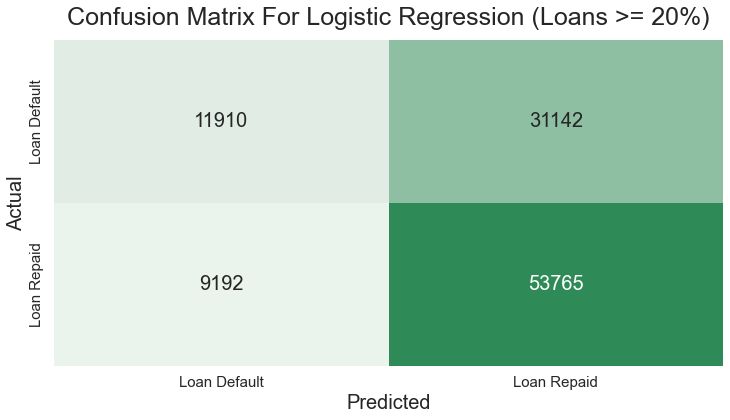

In [22]:
sns.set(rc = {'figure.figsize':(12,6)})
#cmap = sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=True, as_cmap=True)
cmap = sns.light_palette('seagreen', as_cmap=True)

res = sns.heatmap(conf_mat, annot=True, fmt='d', annot_kws={"size":20},
#            xticklabels = ['Good = Paid In Full', 'Bad = Default'],
#            yticklabels = ['Loan Paid In Full', 'Bad = Default'], 
            cmap=cmap, cbar=False)

res.set_xticklabels(['Loan Default', 'Loan Repaid'], fontsize=15)
res.set_yticklabels(['Loan Default', 'Loan Repaid'], fontsize=15)


plt.title('Confusion Matrix For Logistic Regression (Loans >= 20%)', fontsize=25, pad=15)
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20);

In [23]:
accuracy_score(y, y_pred)

0.6195228706996576

In [49]:
precision_score(y, y_pred)

0.6332222313825715

In [24]:
#Accuracy
TN, FP, FN, TP = conf_mat.ravel()
print(TP)
print(FP)
print(FN)
print(TN)
print((TP + TN) / (TN + TP + FP + FN))

53765
31142
9192
11910
0.6195228706996576


In [50]:
#Precision
TP / (TP+FP)

0.6332222313825715

In [25]:
#Re-examine original pool of accepted LC Loans: 

print(data.loan_status_bin.value_counts())
#0 = Loan Defaulted
#1 = Loan Fully Paid

good_loan = data.loan_status_bin.value_counts()[1]
bad_loan = data.loan_status_bin.value_counts()[0]

print()
print(good_loan / (good_loan + bad_loan))

#Random investment would give us 59% chance of pickkng a good loan

1.0    62957
0.0    43052
Name: loan_status_bin, dtype: int64

0.5938835381901537


In [26]:
#Positive Predictive Value (or Precision)
#Logistic Model only does 1.1% better than Null Model or "random investment"
TP / (TP+FP)

0.6332222313825715

In [27]:
#What if we "balance" the weight class to avoid "imbalanced" nature...No Change! 

In [28]:
lr_balanced = LogisticRegression(class_weight='balanced')

In [29]:
steps_balanced = [('model', lr_balanced)]
pipeline_balanced = Pipeline(steps=steps)

In [30]:
#Accuracy:

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
scores = cross_val_score(pipeline_balanced, X, y, scoring='accuracy', cv=cv, n_jobs=-1) 
print(scores)

score = np.mean(scores)
print(score)

[0.61937553 0.61503632 0.6194227  0.62182813 0.62195179]
0.6195228936118736


In [31]:
#Aggregated Confusion Matrix From RepeatedStratifiedKFold: 
y_pred_balanced = cross_val_predict(pipeline_balanced, X, y, cv=cv, n_jobs=-1)
conf_mat_balanced = confusion_matrix(y, y_pred_balanced)
conf_mat_balanced

array([[11910, 31142],
       [ 9192, 53765]])

In [32]:
#Obtain predicted probabilities (not predicted classes) from RSKF: 
y_pred_prob = cross_val_predict(pipeline, X, y, cv=cv, n_jobs=-1, method='predict_proba')

In [33]:
y_pred_prob

array([[0.40625688, 0.59374312],
       [0.44091251, 0.55908749],
       [0.42303919, 0.57696081],
       ...,
       [0.30784073, 0.69215927],
       [0.38089877, 0.61910123],
       [0.23167299, 0.76832701]])

In [34]:
#Obtaining classification based on desired threshold of 0.5 (Same as standard Logistic Regression): 

y_pred_success = (y_pred_prob[:, 1] > 0.50).astype('float')
y_pred_success

array([1., 1., 1., ..., 1., 1., 1.])

In [35]:
conf_mat = confusion_matrix(y, y_pred_success)
conf_mat

array([[11910, 31142],
       [ 9192, 53765]])

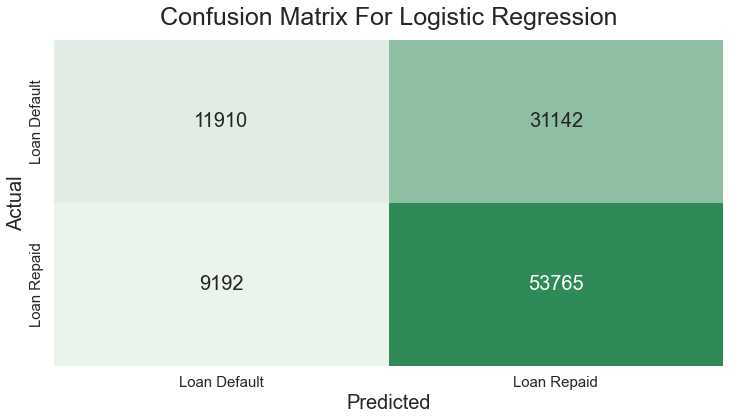

In [36]:
sns.set(rc = {'figure.figsize':(12,6)})
#cmap = sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=True, as_cmap=True)
cmap = sns.light_palette('seagreen', as_cmap=True)

res = sns.heatmap(conf_mat, annot=True, fmt='d', annot_kws={"size":20},
#            xticklabels = ['Good = Paid In Full', 'Bad = Default'],
#            yticklabels = ['Loan Paid In Full', 'Bad = Default'], 
            cmap=cmap, cbar=False)

res.set_xticklabels(['Loan Default', 'Loan Repaid'], fontsize=15)
res.set_yticklabels(['Loan Default', 'Loan Repaid'], fontsize=15)


plt.title('Confusion Matrix For Logistic Regression', fontsize=25, pad=15)
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20);

In [37]:
accuracy_score(y, y_pred_success)

0.6195228706996576

In [38]:
TN, FP, FN, TP = conf_mat.ravel()
print(TP)
print(FP)
print(FN)
print(TN)
print((TP + TN) / (TN + TP + FP + FN))

53765
31142
9192
11910
0.6195228706996576


In [39]:
#Adding Logistic Regression Predictions to loans >= 20%
a['Predicted'] = y_pred_success

In [40]:
a.shape

(106009, 153)

In [47]:
a.tail(7)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,loan_status_bin,Predicted
110137,90300768,NaN,34425.0,34425.0,34125.0,60 months,25.69,1024.40,F,F1,Supervisor,2 years,RENT,72000.0,Source Verified,Oct-2016,Charged Off,n,https://lendingclub.com/browse/loanDetail.action?loan_id=90300768,NaN,debt_consolidation,Debt consolidation,956xx,CA,14.02,0.0,Jul-1998,675.0,679.0,0.0,NaN,74.0,10.0,1.0,11755.0,75.4,23.0,f,0.0,0.0,16393.080000,16250.22,2819.7,6522.73,0.0,7050.65,1269.1170,Jul-2017,1024.40,NaN,Oct-2017,529.0,525.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,20250.0,1.0,2.0,0.0,1.0,15.0,8495.0,49.0,4.0,8.0,5255.0,62.0,15600.0,0.0,8.0,0.0,9.0,2025.0,929.0,89.4,0.0,0.0,116.0,218.0,2.0,2.0,1.0,59.0,NaN,17.0,NaN,0.0,3.0,6.0,3.0,7.0,5.0,8.0,17.0,6.0,10.0,0.0,0.0,0.0,4.0,100.0,66.7,1.0,0.0,32794.0,20250.0,8800.0,17194.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
110138,88877648,NaN,40000.0,40000.0,40000.0,60 months,21.49,1093.19,D,D5,Probation Officer,10+ years,RENT,93400.0,Verified,Oct-2016,Fully Paid,n,https://lendingclub.com/browse/loanDetail.action?loan_id=88877648,NaN,debt_consolidation,Debt consolidation,088xx,NJ,14.09,0.0,Jun-1983,705.0,709.0,0.0,NaN,NaN,8.0,0.0,48414.0,81.8,14.0,f,0.0,0.0,52583.971972,52583.97,40000.0,12583.97,0.0,0.00,0.0000,May-2018,32954.31,NaN,May-2018,744.0,740.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,48414.0,0.0,0.0,0.0,0.0,124.0,0.0,NaN,0.0,0.0,23450.0,82.0,59200.0,0.0,1.0,0.0,0.0,8069.0,4854.0,90.8,0.0,0.0,147.0,399.0,29.0,29.0,0.0,29.0,NaN,NaN,NaN,0.0,3.0,6.0,3.0,4.0,

In [44]:
#Segregating loans that were expected to perform by Logistic Regression
chosen = a[a.Predicted==1]
chosen.shape

(84907, 153)

In [45]:
#Overall Return On Investment If Invested In Loans Predicted By LR ==> -0.01%
chosen['total_pymnt_inv'].sum() / chosen['funded_amnt_inv'].sum()

0.9998072301734612